**Submission Dicoding**

**Proyek Pertama: Membuat Model NLP dengan TensorFlow**

Ita Sulistiani / itasulis16@gmail.com

username : haru.haruru_

In [1]:
# install package untuk kaggle
!pip install -q kaggle

In [2]:
# upload file kredensial kaggle.json
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"itasulistiani","key":"37ebf60897a6a643775b64e4303c7e94"}'}

In [3]:
# membuat direktori dan merubah izin
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle

kaggle.json


In [4]:
# download dataset
!kaggle datasets download -d yufengdev/bbc-fulltext-and-category

  0% 0.00/1.83M [00:00<?, ?B/s]
100% 1.83M/1.83M [00:00<00:00, 59.2MB/s]


In [5]:
# ekstraksi file
!mkdir bbctext
!unzip bbc-fulltext-and-category.zip -d bbctext
!ls bbctext

Archive:  bbc-fulltext-and-category.zip
  inflating: bbctext/bbc-text.csv    
bbc-text.csv


Load Dataset

In [6]:
import pandas as pd

df = pd.read_csv('/content/bbctext/bbc-text.csv')
df.tail(5)

,category,text
2220,business,cars pull down us retail figures us retail sal...
2221,politics,kilroy unveils immigration policy ex-chatshow ...
2222,entertainment,rem announce new glasgow concert us band rem h...
2223,politics,how political squabbles snowball it s become c...
2224,sport,souness delight at euro progress boss graeme s...


In [7]:
# cek total data
df.shape

(2225, 2)

In [8]:
# cek jumlah item per kategori

df.category.value_counts()

sport            511
business         510
politics         417
tech             401
entertainment    386
Name: category, dtype: int64

Data Preprocessing

In [9]:
# import tools

import numpy as np
import re
import nltk
import spacy
import string
from nltk.corpus import stopwords

pd.options.mode.chained_assignment = None

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [10]:
df_new = df

# lower casing content
df_new['text'] = df_new['text'].str.lower()

# menghapus punctuation
PUNCT_TO_REMOVE = string.punctuation
def remove_punctuation(text):
  return text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))

df_new['text'] = df_new['text'].apply(lambda text: remove_punctuation(text))
df_new.head()

# menghapus stopwords
STOPWORDS = set(stopwords.words('english'))
def remove_stopwords(text):
  return " ".join([word for word in str(text).split() if word not in STOPWORDS])
df_new['text'] = df_new['text'].apply(lambda text: remove_stopwords(text))

df_new.head()

,category,text
0,tech,tv future hands viewers home theatre systems p...
1,business,worldcom boss left books alone former worldcom...
2,sport,tigers wary farrell gamble leicester say rushe...
3,sport,yeading face newcastle fa cup premiership side...
4,entertainment,ocean twelve raids box office ocean twelve cri...


In [11]:
# menghitung frequent words

from collections import Counter

cnt = Counter()
for text in df_new['text'].values:
  for word in text.split():
    cnt[word] += 1
cnt.most_common(10)

[('said', 7254),
 ('mr', 3004),
 ('would', 2577),
 ('also', 2156),
 ('people', 2043),
 ('new', 1970),
 ('us', 1924),
 ('year', 1829),
 ('one', 1763),
 ('could', 1511)]

In [12]:
# menghapus frequent word

FREQWORDS = set([w for (w, wc) in cnt.most_common(10)])

def remove_freqwords(text):
  return " ".join([word for word in str(text).split() if word not in FREQWORDS])
df_new['text'] = df_new['text'].apply(lambda text: remove_freqwords(text))


In [13]:
# menghapus kata-kata yang jarang muncul

n_rare_words = 10
RAREWORDS = set([w for (w, wc) in cnt.most_common()[:-n_rare_words-1:-1]])

def remove_rarewords(text):
  return " ".join([word for word in str(text).split() if word not in RAREWORDS])

df_new['text'] = df_new['text'].apply(lambda text: remove_rarewords(text))

In [14]:
# lemmatization

from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet 
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [15]:
lemmatizer = WordNetLemmatizer()

def lemmatization(text):
  pos_dict = {'N': wordnet.NOUN, 'V': wordnet.VERB, 'J': wordnet.ADJ, 'R': wordnet.ADV}
  return(" ".join([lemmatizer.lemmatize(w, pos_dict.get(k, wordnet.NOUN)) for w, k in nltk.pos_tag(text.split())]))

df_new['text'] = df_new['text'].apply(lambda text: lemmatization(text))

In [16]:
# menghapus nomor

def remove_numb(text):
  return re.sub('[0-9]+', '', text)

df_new['text'] = df_new['text'].apply(remove_numb)


In [17]:
# cek data setelah preprocessing

df_new.head(10)

,category,text
0,tech,tv future hand viewer home theatre system plas...
1,business,worldcom bos left book alone former worldcom b...
2,sport,tiger wary farrell gamble leicester say rushed...
3,sport,yeading face newcastle fa cup premiership side...
4,entertainment,ocean twelve raid box office ocean twelve crim...
5,politics,howard hit back mongrel jibe michael howard cl...
6,politics,blair prepares name poll date tony blair likel...
7,sport,henman hope ended dubai third seed tim henman ...
8,sport,wilkinson fit face edinburgh england captain j...
9,entertainment,last star war child sixth final star war movie...


In [18]:
# melakukan one hot encoding untuk label category karena merupakan data kategorikal

category = pd.get_dummies(df_new.category)
category

,business,entertainment,politics,sport,tech
0,0,0,0,0,1
1,1,0,0,0,0
2,0,0,0,1,0
3,0,0,0,1,0
4,0,1,0,0,0
...,...,...,...,...,...
2220,1,0,0,0,0
2221,0,0,1,0,0
2222,0,1,0,0,0
2223,0,0,1,0,0


In [19]:
# menyatukan dataframe kategori dengan dataframe baru

df_new = pd.concat([df_new, category], axis = 1)
df_new

,category,text,business,entertainment,politics,sport,tech
0,tech,tv future hand viewer home theatre system plas...,0,0,0,0,1
1,business,worldcom bos left book alone former worldcom b...,1,0,0,0,0
2,sport,tiger wary farrell gamble leicester say rushed...,0,0,0,1,0
3,sport,yeading face newcastle fa cup premiership side...,0,0,0,1,0
4,entertainment,ocean twelve raid box office ocean twelve crim...,0,1,0,0,0
...,...,...,...,...,...,...,...
2220,business,car pull retail figure retail sale fell janua...,1,0,0,0,0
2221,politics,kilroy unveils immigration policy exchatshow h...,0,0,1,0,0
2222,entertainment,rem announce glasgow concert band rem announce...,0,1,0,0,0
2223,politics,political squabble snowball become commonplace...,0,0,1,0,0


In [20]:
# drop kolom category karena sudah tidak diperlukan

df_new = df_new.drop(columns='category')

In [21]:
# cek kolom yang tersedia

df_new.columns

Index(['text', 'business', 'entertainment', 'politics', 'sport', 'tech'], dtype='object')

In [22]:
# mengubah nilai dataframe ke tipe numpy array agar bisa diproses model

content = df_new['text'].values
label = df_new[['business', 'entertainment', 'politics', 'sport', 'tech']].values

In [23]:
content

array(['tv future hand viewer home theatre system plasma highdefinition tv digital video recorder moving living room way watch tv radically different five year time according expert panel gathered annual consumer electronics show la vega discus technology impact favourite pastime leading trend programme content delivered viewer via home network cable satellite telecom company broadband service provider front room portable device talkedabout technology ce digital personal video recorder dvr pvr settop box like tivo uk sky system allow record store play pause forward wind tv programme want essentially technology allows much personalised tv builtin highdefinition tv set big business japan slower take europe lack highdefinition programming forward wind advert forget abiding network channel schedule putting together alacarte entertainment network cable satellite company worried mean term advertising revenue well brand identity viewer loyalty channel although lead technology moment concern r

In [24]:
label

array([[0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0],
       ...,
       [0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 0, 1, 0]], dtype=uint8)

In [25]:
# membagi data untuk training dan testing

from sklearn.model_selection import train_test_split

content_train, content_test, label_train, label_test = train_test_split(content, label, test_size = 0.2)

In [26]:
# tokenisasi kata pada dataset kemudian konversi sampel menjadi sequence

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [27]:
# tokenisasi
tokenizer = Tokenizer(num_words=5000, oov_token='x', filters='!"#$%&()*+,-./:;<=>@[\]^_`{|}~ ')
tokenizer.fit_on_texts(content_train)
tokenizer.fit_on_texts(content_test)

# konversi ke sequence
sequence_train = tokenizer.texts_to_sequences(content_train)
sequence_test = tokenizer.texts_to_sequences(content_test)

# padding teks
padded_train = pad_sequences(sequence_train)
padded_test = pad_sequences(sequence_test)

In [28]:
# membangun arsitektur model

import tensorflow as tf

model = tf.keras.Sequential([
                             tf.keras.layers.Embedding(input_dim=5000, output_dim=64),
                             tf.keras.layers.LSTM(128),
                             tf.keras.layers.Dense(256, activation='relu'),
                             tf.keras.layers.Dense(128, activation='relu'),
                             tf.keras.layers.Dropout(0.5),
                             tf.keras.layers.Dense(5, activation='softmax')
])

In [29]:
# mengkompilasi model menggunakan optimizer 'adam' dan loss function 'categorical_crossentropy'

model.compile(loss='categorical_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 64)          320000    
_________________________________________________________________
lstm (LSTM)                  (None, 128)               98816     
_________________________________________________________________
dense (Dense)                (None, 256)               33024     
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 645       
Total params: 485,381
Trainable params: 485,381
Non-trainable params: 0
__________________________________________________

In [30]:
# metode callback function untuk stop training jika akurasi telah di atas 90%

class Callback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy') > 0.90 and logs.get('val_accuracy') > 0.90):
      self.model.stop_training = True

stop_training = Callback()

In [31]:
# training model

num_epochs = 50
training_history = model.fit(
    padded_train, label_train,
    epochs = num_epochs,
    validation_data = (padded_test, label_test),
    verbose = 2,
    callbacks = [stop_training]
)

Epoch 1/50
56/56 - 137s - loss: 1.5705 - accuracy: 0.2663 - val_loss: 1.3984 - val_accuracy: 0.3618
Epoch 2/50
56/56 - 134s - loss: 0.8930 - accuracy: 0.5961 - val_loss: 0.7783 - val_accuracy: 0.6607
Epoch 3/50
56/56 - 134s - loss: 0.4184 - accuracy: 0.8292 - val_loss: 0.5970 - val_accuracy: 0.8247
Epoch 4/50
56/56 - 134s - loss: 0.1042 - accuracy: 0.9708 - val_loss: 0.4859 - val_accuracy: 0.8629
Epoch 5/50
56/56 - 134s - loss: 0.0473 - accuracy: 0.9876 - val_loss: 0.4142 - val_accuracy: 0.8876
Epoch 6/50
56/56 - 134s - loss: 0.0307 - accuracy: 0.9938 - val_loss: 0.4458 - val_accuracy: 0.8944
Epoch 7/50
56/56 - 134s - loss: 0.0392 - accuracy: 0.9910 - val_loss: 0.5299 - val_accuracy: 0.8787
Epoch 8/50
56/56 - 134s - loss: 0.0035 - accuracy: 0.9989 - val_loss: 0.5545 - val_accuracy: 0.8787
Epoch 9/50
56/56 - 134s - loss: 0.0126 - accuracy: 0.9966 - val_loss: 0.6206 - val_accuracy: 0.8719
Epoch 10/50
56/56 - 134s - loss: 0.0023 - accuracy: 0.9994 - val_loss: 0.6022 - val_accuracy: 0.8809

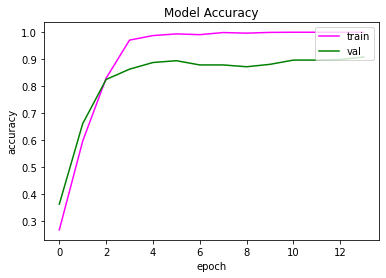

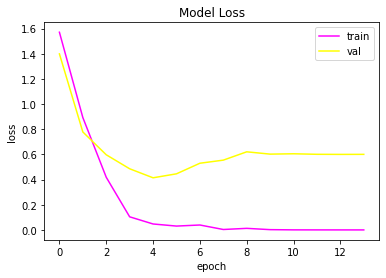

In [32]:
# visualisasi training model

import matplotlib.pyplot as plt

accuracy = training_history.history['accuracy']
val_accuracy = training_history.history['val_accuracy']

loss = training_history.history['loss']
val_loss = training_history.history['val_loss']

plt.plot(accuracy, color = 'magenta')
plt.plot(val_accuracy, color = 'green')
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc = 'upper right')
plt.show()

plt.plot(loss, color = 'magenta')
plt.plot(val_loss, color = 'yellow')
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()